/tmp/ipykernel_4020/3555429547.py:189: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap(colors)


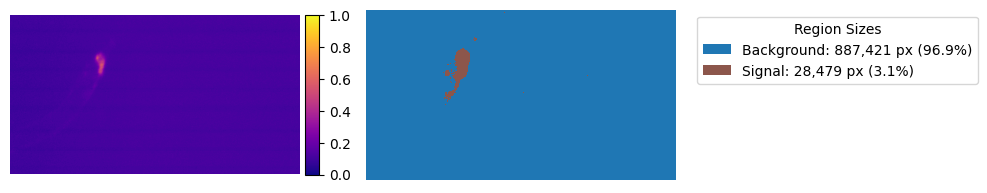

In [9]:
import os
from tqdm import tqdm
import glob
from PIL import Image, ImageSequence
import numpy as np
import cv2
from loguru import logger
from pathlib import Path
import inspect
import traceback
from hyperscope.helpers.concurrency import ConcurrentTqdm
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.cluster import KMeans
from typing import List, Optional, Union
from scipy import ndimage
from skimage.filters import threshold_otsu
from hyperscope.helpers.func import flatten
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl
from matplotlib.figure import Figure
from hyperscope import config


def format_error_message(e: Exception) -> str:
    """Format error message with stack trace information."""
    try:
        raise e
    except Exception as e:
        frame = inspect.currentframe()
        caller_frame = frame.f_back
        filename = caller_frame.f_code.co_filename
        line_number = caller_frame.f_lineno

        error_details = {
            "error_type": type(e).__name__,
            "error_message": str(e),
            "filename": filename,
            "line_number": line_number,
            "traceback": "".join(traceback.format_exc()),
        }

        return (
            f"Error processing batch:\n"
            f"Location: {error_details['filename']}:{error_details['line_number']}\n"
            f"Error Type: {error_details['error_type']}\n"
            f"Message: {error_details['error_message']}\n"
            f"Traceback:\n{error_details['traceback']}"
        )


def split_tifs(paths: List[str], output_dir):
    """Extract pages from multipage TIF files."""
    paths = [path for path in paths if path.endswith(".tif") or path.endswith(".tiff")]
    extracted = Path(output_dir) / "extracted"
    extracted.mkdir(parents=True, exist_ok=True)
    images = [Image.open(path) for path in paths]
    image_with_path = zip(images, paths)
    new_paths = []
    for img, path in tqdm(image_with_path, desc="extracting pages"):
        base_filename = os.path.basename(path)
        name, _ = os.path.splitext(base_filename)
        for i, page in enumerate(ImageSequence.Iterator(img)):
            output_filename = extracted / f"{name}_page_{i+1}.npy"
            if output_filename.exists():
                new_paths.append(str(output_filename))
                continue
            np.save(output_filename, np.array(img))
            new_paths.append(str(output_filename))
    return paths, new_paths


def process_paths(input_patterns, output_dir, exclude_pattern=None):
    """Process and filter file paths based on input patterns and exclusions."""
    all_paths = flatten([glob.glob(input_pattern) for input_pattern in input_patterns])
    exclude_paths = glob.glob(exclude_pattern) if exclude_pattern else ""
    final_paths = list(set(all_paths) - set(exclude_paths))
    old_paths, new_paths = split_tifs(final_paths, output_dir)
    final_paths = list((set(final_paths) - set(old_paths)) | set(new_paths))
    final_paths.sort(reverse=True)
    return [Path(p) for p in final_paths]


def minmax_norm(image, minval=0, maxval=1, dtype=np.float32):
    """Normalize image to range [minval, maxval]"""
    return np.clip(
        ((image - image.min()) / (image.max() - image.min()) * (maxval - minval)) + minval,
        minval,
        maxval,
    ).astype(dtype)


def kmeans_segmentation(image, n_clusters, spatial_weight=1.0, seed=128):
    """Perform k-means segmentation on the image"""
    image = minmax_norm(image.copy())
    h, w = image.shape
    y_coords, x_coords = np.mgrid[0:h, 0:w]

    x_coords = x_coords / float(w)
    y_coords = y_coords / float(h)

    features = np.stack([x_coords * spatial_weight, y_coords * spatial_weight, image]).transpose(
        1, 2, 0
    )
    features = features.reshape(-1, 3)

    kmeans = KMeans(n_clusters=n_clusters, random_state=seed)
    labels = kmeans.fit_predict(features)

    return labels.reshape(h, w)


def sort_labels(labels):
    """Sort labels by frequency"""
    categories, counts = np.unique(labels, return_counts=True)
    sorted_categories = np.argsort(-counts)
    label_mapping = {old_label: new_label for new_label, old_label in enumerate(sorted_categories)}
    sorted_label_array = np.zeros_like(labels)
    for old_label, new_label in label_mapping.items():
        sorted_label_array[labels == old_label] = new_label

    sorted_counts = [counts[old_label] for _, old_label in enumerate(sorted_categories)]
    return sorted_label_array, sorted_categories, sorted_counts


def label2rgb(label, cmap="tab10", bg_label=0, bg_color=[0, 0, 0]):
    """Convert label image to RGB."""
    cmap = plt.cm.get_cmap(cmap)
    unique_categories = np.unique(label)
    colors = [
        bg_color if cat == bg_label else cmap(cat / max(unique_categories))
        for cat in unique_categories
    ]
    if len(colors) < 3:
        colors = [[0, 0, 0], [1, 0, 0], [0, 1, 0]]
    segmentation_image = np.zeros((*label.shape, 3), dtype=np.uint8)
    for i, c in enumerate(colors):
        segmentation_image[label == i] = np.clip(np.array(c[:3]) * 255, 0, 255).astype(np.uint8)
    return segmentation_image, colors


def create_verification_plot(
    disp_img: np.ndarray,
    segmentation_image: np.ndarray,
    colors: Union[List, str],
    unique_categories: np.ndarray,
    counts: np.ndarray,
    catmap: List[str] = ["Background", "Auto Fluorescence", "Signal"],
) -> Figure:
    """
    Create a verification plot comparing original and segmented images.

    Args:
        disp_img: Original image array
        segmentation_image: Segmented image array
        colors: List of colors or colormap name
        unique_categories: Array of unique category labels
        counts: Array of pixel counts for each category
        catmap: List of category names

    Returns:
        matplotlib.figure.Figure: The created figure
    """
    # Normalize display image
    disp_img = (disp_img - disp_img.min()) / (disp_img.max() - disp_img.min())

    # Create figure
    fig = plt.figure(figsize=(10, 7))

    # Ensure we have enough category names
    if len(catmap) < len(unique_categories):
        catmap = [f"Region {i}" for i in range(len(unique_categories))]

    # Plot original image
    ax_original = fig.add_subplot(121)
    im = ax_original.imshow(disp_img, vmin=0, vmax=1, cmap="plasma")
    ax_original.set_axis_off()

    # Add colorbar to original image
    divider = make_axes_locatable(ax_original)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im, cax=cax, orientation="vertical")

    # Handle colors and create colormap
    if isinstance(colors, list):
        cmap = LinearSegmentedColormap.from_list("colors", colors, N=len(colors))
    elif isinstance(colors, str):
        cmap = mpl.cm.get_cmap(colors)
        colors = [cmap(i / len(unique_categories)) for i in range(len(unique_categories))]
        cmap = LinearSegmentedColormap.from_list("colors", colors, N=len(colors))

    # Plot segmentation
    ax_segmented = fig.add_subplot(122)
    ax_segmented.imshow(segmentation_image, cmap=cmap)
    ax_segmented.set_axis_off()

    # Create legend
    total_pixels = disp_img.size
    legend_elements = [
        Patch(
            facecolor=colors[i],
            label=f"{catmap[i]}: {count:,} px ({(count/total_pixels)*100:.1f}%)",
        )
        for i, count in enumerate(counts)
    ]

    ax_segmented.legend(
        handles=legend_elements, title="Region Sizes", bbox_to_anchor=(1.05, 1), loc="upper left"
    )

    fig.tight_layout()
    return fig


def process_image(img, crop, df):
    """Process a single image using the new pipeline."""
    dt = img.dtype
    maxval = np.iinfo(dt).max

    if crop:
        x1, y1, x2, y2 = crop
        img = img[y1:y2, x1:x2]
        df = df[y1:y2, x1:x2]

    # Initial normalization
    img = minmax_norm(img)

    # Darkframe correction
    img -= df
    return_img = minmax_norm(img.copy(), 0, maxval, np.uint16)

    # Create and clean mask
    mask = img > threshold_otsu(img)
    mask = ndimage.binary_opening(mask, iterations=1)

    # Remove small objects
    labeled_regions, num_features = ndimage.label(mask)
    sizes = ndimage.sum(mask, labeled_regions, range(1, num_features + 1))
    mask_sizes = sizes > 25
    cleaned_mask = mask_sizes[labeled_regions - 1]

    img *= cleaned_mask
    # Final filtering
    #filtered = ndimage.gaussian_filter(img, 1)
    # final_mask = filtered > 0.01
    final_mask = img > 0
    # img *= final_mask
    # np.nan_to_num(img, False, 0)
    # Perform segmentation
    # labels = kmeans_segmentation(img, 2, 0)
    # sorted_label_array, sorted_categories, sorted_counts = sort_labels(labels)
    sorted_label_array, sorted_categories, sorted_counts = sort_labels(final_mask)

    return return_img, sorted_label_array, sorted_categories, sorted_counts


def process_images(paths: [Path], crop=None, df_dir=None):
    """Process a batch of images."""
    img_shape = np.load(paths[0]).shape
    df_paths = list(df_dir.glob("*.npy")) if df_dir is not None else []

    if len(df_paths) > 0:
        df = np.sum([np.load(f).astype(np.uint16) for f in df_paths], axis=0)
        df = df.clip(0, np.iinfo(np.uint16).max)
        df = minmax_norm(df)
    else:
        df = np.zeros(img_shape, dtype=np.uint16)

    for img_path in paths:
        img_name = img_path.stem
        img = np.load(img_path).astype(np.uint16)
        img, labels, categories, counts = process_image(img, crop, df)
        sig_percent = (labels[labels > 0]).size / img.size
        if len(categories) < 2 or sig_percent < 0.005 or sig_percent > 0.1:
            continue
        signal_key = img_name.split("_")[0]

        # segmentation_image, colors = label2rgb(labels)
        # fig = create_verification_plot(img, segmentation_image, colors, categories, counts)
        fig = create_verification_plot(
            img, labels, "tab10", categories, counts, catmap=["Background", "Signal"]
        )
        plt.show()
        plt.close(fig)


process_images(
    [config.INTERIM_DATA_DIR
    / "worms"
    / "extracted"
    / "mkate_live_2025-01-13T10-31-47.631_1_page_302.npy"],
    crop=[150, 150, 1440, 860],
    df_dir=config.RAW_DATA_DIR / "worms" / "darkframe",
)

In [10]:
import os
from tqdm import tqdm
import glob
from PIL import Image, ImageSequence
import numpy as np
import cv2
from loguru import logger
from pathlib import Path
import inspect
import traceback
from hyperscope.helpers.concurrency import ConcurrentTqdm
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.cluster import KMeans
from typing import List, Optional, Union
from scipy import ndimage
from skimage.filters import threshold_otsu
from hyperscope.helpers.func import flatten
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl
from matplotlib.figure import Figure
from hyperscope import config
import supervision as sv
from supervision.annotators.utils import ColorLookup
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry
import torch

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"
CHECKPOINT_PATH = config.MODELS_DIR / 'sam_vit_h_4b8939.pth'
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH)
sam.to(device=DEVICE)
mask_generator = SamAutomaticMaskGenerator(sam)


def format_error_message(e: Exception) -> str:
    """Format error message with stack trace information."""
    try:
        raise e
    except Exception as e:
        frame = inspect.currentframe()
        caller_frame = frame.f_back
        filename = caller_frame.f_code.co_filename
        line_number = caller_frame.f_lineno

        error_details = {
            "error_type": type(e).__name__,
            "error_message": str(e),
            "filename": filename,
            "line_number": line_number,
            "traceback": "".join(traceback.format_exc()),
        }

        return (
            f"Error processing batch:\n"
            f"Location: {error_details['filename']}:{error_details['line_number']}\n"
            f"Error Type: {error_details['error_type']}\n"
            f"Message: {error_details['error_message']}\n"
            f"Traceback:\n{error_details['traceback']}"
        )


def split_tifs(paths: List[str], output_dir):
    """Extract pages from multipage TIF files."""
    paths = [path for path in paths if path.endswith(".tif") or path.endswith(".tiff")]
    extracted = Path(output_dir) / "extracted"
    extracted.mkdir(parents=True, exist_ok=True)
    images = [Image.open(path) for path in paths]
    image_with_path = zip(images, paths)
    new_paths = []
    for img, path in tqdm(image_with_path, desc="extracting pages"):
        base_filename = os.path.basename(path)
        name, _ = os.path.splitext(base_filename)
        for i, page in enumerate(ImageSequence.Iterator(img)):
            output_filename = extracted / f"{name}_page_{i+1}.npy"
            if output_filename.exists():
                new_paths.append(str(output_filename))
                continue
            np.save(output_filename, np.array(img))
            new_paths.append(str(output_filename))
    return paths, new_paths


def process_paths(input_patterns, output_dir, exclude_pattern=None):
    """Process and filter file paths based on input patterns and exclusions."""
    all_paths = flatten([glob.glob(input_pattern) for input_pattern in input_patterns])
    exclude_paths = glob.glob(exclude_pattern) if exclude_pattern else ""
    final_paths = list(set(all_paths) - set(exclude_paths))
    old_paths, new_paths = split_tifs(final_paths, output_dir)
    final_paths = list((set(final_paths) - set(old_paths)) | set(new_paths))
    final_paths.sort(reverse=True)
    return [Path(p) for p in final_paths]


def minmax_norm(image, minval=0, maxval=1, dtype=np.float32):
    """Normalize image to range [minval, maxval]"""
    return np.clip(
        ((image - image.min()) / (image.max() - image.min()) * (maxval - minval)) + minval,
        minval,
        maxval,
    ).astype(dtype)


def kmeans_segmentation(image, n_clusters, spatial_weight=1.0, seed=128):
    """Perform k-means segmentation on the image"""
    image = minmax_norm(image.copy())
    h, w = image.shape
    y_coords, x_coords = np.mgrid[0:h, 0:w]

    x_coords = x_coords / float(w)
    y_coords = y_coords / float(h)

    features = np.stack([x_coords * spatial_weight, y_coords * spatial_weight, image]).transpose(
        1, 2, 0
    )
    features = features.reshape(-1, 3)

    kmeans = KMeans(n_clusters=n_clusters, random_state=seed)
    labels = kmeans.fit_predict(features)

    return labels.reshape(h, w)


def sort_labels(labels):
    """Sort labels by frequency"""
    categories, counts = np.unique(labels, return_counts=True)
    sorted_categories = np.argsort(-counts)
    label_mapping = {old_label: new_label for new_label, old_label in enumerate(sorted_categories)}
    sorted_label_array = np.zeros_like(labels)
    for old_label, new_label in label_mapping.items():
        sorted_label_array[labels == old_label] = new_label

    sorted_counts = [counts[old_label] for _, old_label in enumerate(sorted_categories)]
    return sorted_label_array, sorted_categories, sorted_counts


def label2rgb(label, cmap="tab10", bg_label=0, bg_color=[0, 0, 0]):
    """Convert label image to RGB."""
    cmap = plt.cm.get_cmap(cmap)
    unique_categories = np.unique(label)
    colors = [
        bg_color if cat == bg_label else cmap(cat / max(unique_categories))
        for cat in unique_categories
    ]
    if len(colors) < 3:
        colors = [[0, 0, 0], [1, 0, 0], [0, 1, 0]]
    segmentation_image = np.zeros((*label.shape, 3), dtype=np.uint8)
    for i, c in enumerate(colors):
        segmentation_image[label == i] = np.clip(np.array(c[:3]) * 255, 0, 255).astype(np.uint8)
    return segmentation_image, colors


def create_verification_plot(
    disp_img: np.ndarray,
    segmentation_image: np.ndarray,
    colors: Union[List, str],
    unique_categories: np.ndarray,
    counts: np.ndarray,
    catmap: List[str] = ["Background", "Auto Fluorescence", "Signal"],
) -> Figure:
    """
    Create a verification plot comparing original and segmented images.

    Args:
        disp_img: Original image array
        segmentation_image: Segmented image array
        colors: List of colors or colormap name
        unique_categories: Array of unique category labels
        counts: Array of pixel counts for each category
        catmap: List of category names

    Returns:
        matplotlib.figure.Figure: The created figure
    """
    # Normalize display image
    disp_img = (disp_img - disp_img.min()) / (disp_img.max() - disp_img.min())

    # Create figure
    fig = plt.figure(figsize=(10, 7))

    # Ensure we have enough category names
    if len(catmap) < len(unique_categories):
        catmap = [f"Region {i}" for i in range(len(unique_categories))]

    # Plot original image
    ax_original = fig.add_subplot(121)
    im = ax_original.imshow(disp_img, vmin=0, vmax=1, cmap="plasma")
    ax_original.set_axis_off()

    # Add colorbar to original image
    divider = make_axes_locatable(ax_original)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im, cax=cax, orientation="vertical")

    # Handle colors and create colormap
    if isinstance(colors, list):
        cmap = LinearSegmentedColormap.from_list("colors", colors, N=len(colors))
    elif isinstance(colors, str):
        cmap = mpl.cm.get_cmap(colors)
        colors = [cmap(i / len(unique_categories)) for i in range(len(unique_categories))]
        cmap = LinearSegmentedColormap.from_list("colors", colors, N=len(colors))

    # Plot segmentation
    ax_segmented = fig.add_subplot(122)
    ax_segmented.imshow(segmentation_image, cmap=cmap)
    ax_segmented.set_axis_off()

    # Create legend
    total_pixels = disp_img.size
    legend_elements = [
        Patch(
            facecolor=colors[i],
            label=f"{catmap[i]}: {count:,} px ({(count/total_pixels)*100:.1f}%)",
        )
        for i, count in enumerate(counts)
    ]

    ax_segmented.legend(
        handles=legend_elements, title="Region Sizes", bbox_to_anchor=(1.05, 1), loc="upper left"
    )

    fig.tight_layout()
    return fig


def process_image(img, crop, df, dt=None):
    """Process a single image using the new pipeline."""
    dt = img.dtype if dt is None else dt
    maxval = np.iinfo(dt).max

    if crop:
        x1, y1, x2, y2 = crop
        img = img[y1:y2, x1:x2]
        df = df[y1:y2, x1:x2]

    # Initial normalization
    img = minmax_norm(img)

    # Darkframe correction
    img -= df
    return_img = minmax_norm(img.copy(), 0, maxval, dt)

    image_rgb = cv2.cvtColor(return_img, cv2.COLOR_GRAY2RGB)
    result = mask_generator.generate(image_rgb)
    # sorted_label_array, sorted_categories, sorted_counts = sort_labels(final_mask)
    mask_annotator = sv.MaskAnnotator(color_lookup=ColorLookup.INDEX)
    detections = sv.Detections.from_sam(result)
    annotated_image = mask_annotator.annotate(cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR), detections)
    # fig = create_verification_plot(
    #     img, labels, "tab10", categories, counts, catmap=["Background", "Signal"]
    # )
    # plt.show()
    # plt.close(fig)
    return return_img, detections, annotated_image


def process_images(paths: [Path], crop=None, df_dir=None):
    """Process a batch of images."""
    img_shape = np.load(paths[0]).shape
    df_paths = list(df_dir.glob("*.npy")) if df_dir is not None else []
    detections = []

    if len(df_paths) > 0:
        df = np.sum([np.load(f).astype(np.uint16) for f in df_paths], axis=0)
        df = df.clip(0, np.iinfo(np.uint16).max)
        df = minmax_norm(df)
    else:
        df = np.zeros(img_shape, dtype=np.uint16)

    for img_path in paths:
        img_name = img_path.stem
        img = np.load(img_path).astype(np.uint16)
        detections.append(process_image(img, crop, df, np.uint8))
        # sig_percent = (labels[labels > 0]).size / img.size
        # if len(categories) < 2 or sig_percent < 0.005 or sig_percent > 0.1:
        #     continue
        # signal_key = img_name.split("_")[0]

        # # segmentation_image, colors = label2rgb(labels)
        # # fig = create_verification_plot(img, segmentation_image, colors, categories, counts)
        # fig = create_verification_plot(
        #     img, labels, "tab10", categories, counts, catmap=["Background", "Signal"]
        # )
        # plt.show()
        # plt.close(fig)
    return detections


detections = process_images(
    [config.INTERIM_DATA_DIR
    / "worms"
    / "extracted"
    #/ "mkate_live_2025-01-13T10-31-47.631_1_page_302.npy"
    / "mch_live_2025-01-13T10-49-35.611_0_page_5.npy"
    ],
    crop=[150, 150, 1440, 860],
    df_dir=config.RAW_DATA_DIR / "worms" / "darkframe",
)

0.07751937984496124


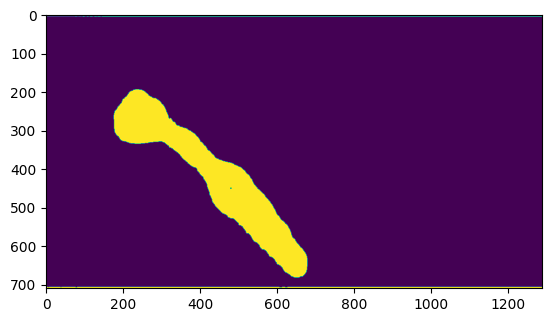

: 

In [ ]:
# < .01% or >

m = ~detections[0][1].mask[0]
print(len(m == True) / m.size * 100)
plt.imshow(m)